## Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification
from tqdm.notebook import tqdm
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
df = pd.read_csv('/content/gdrive/MyDrive/ML Project/Womens Clothing E-Commerce Reviews.csv')

## Data Preprocessing

In [4]:
df.columns

Index(['Unnamed: 0', 'Clothing ID', 'Age', 'Title', 'Review Text', 'Rating',
       'Recommended IND', 'Positive Feedback Count', 'Division Name',
       'Department Name', 'Class Name'],
      dtype='object')

Drop Some Features

In [5]:
df = df.drop(['Unnamed: 0', 'Clothing ID', 'Positive Feedback Count', 'Division Name'], axis=1)

Combine Recommended IND, Age, Department, Class, Title and Review

In [6]:
df['Combined Text'] = df.apply(lambda row: "{0} My age is {1} years.{2}{3}{4}{5}".format(
    "I recommend this item." if row['Recommended IND'] == 1 else "I don't recommend this item.",
    row["Age"],
    f" This item is from the {row['Department Name']} department." if not pd.isna(row['Department Name']) else "",
    f" It falls under the {row['Class Name']} class." if not pd.isna(row['Class Name']) else "",
    f" {row['Title']}." if not pd.isna(row['Title']) else "",
    f" {row['Review Text']}" if not pd.isna(row['Review Text']) else "",
), axis=1)

Lowercase

In [7]:
df['Combined Text'] = df['Combined Text'].str.lower()

In [8]:
df.shape

(23486, 8)

In [9]:
df.head(5)

,Age,Title,Review Text,Rating,Recommended IND,Department Name,Class Name,Combined Text
0,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,Intimate,Intimates,i recommend this item. my age is 33 years. thi...
1,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,Dresses,Dresses,i recommend this item. my age is 34 years. thi...
2,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,Dresses,Dresses,i don't recommend this item. my age is 60 year...
3,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,Bottoms,Pants,i recommend this item. my age is 50 years. thi...
4,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,Tops,Blouses,i recommend this item. my age is 47 years. thi...


In [10]:
df['Rating'].value_counts(normalize = True)

5    0.559099
4    0.216171
3    0.122243
2    0.066635
1    0.035851
Name: Rating, dtype: float64

Train-Validation-Test Split

In [11]:
X = df['Combined Text'].values
y = pd.get_dummies(df['Rating']).values

X_train, X_temp, y_train, y_temp = train_test_split(
    X,
    y,
    test_size=0.3,
    random_state=42,
    stratify=y
  )

X_val, X_test, y_val, y_test = train_test_split(
    X_temp,
    y_temp,
    test_size=0.5,
    random_state=42,
    stratify=y_temp
)

X_train.shape, X_val.shape, X_test.shape

((16440,), (3523,), (3523,))

## Data Formatting

In [12]:
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Find Max Token Length

In [13]:
token_length = np.array([len(tokenizer.encode(row, add_special_tokens=True)) for row in tqdm(X)])
max_token_length = max(token_length)

  0%|          | 0/23486 [00:00<?, ?it/s]

In [14]:
X_train_tokens = tokenizer(
    X_train.tolist(),
    add_special_tokens=True,
    max_length=max_token_length,
    pad_to_max_length=True,
    padding='max_length',
    truncation=True,
    return_attention_mask=True,
    return_tensors='tf'
)

In [15]:
X_val_tokens = tokenizer(
    X_val.tolist(),
    add_special_tokens=True,
    max_length=max_token_length,
    pad_to_max_length=True,
    padding='max_length',
    truncation=True,
    return_attention_mask=True,
    return_tensors='tf'
)

In [16]:
X_test_tokens = tokenizer(
    X_test.tolist(),
    add_special_tokens=True,
    max_length=max_token_length,
    pad_to_max_length=True,
    padding='max_length',
    truncation=True,
    return_attention_mask=True,
    return_tensors='tf'
)

## Model Architecture

1. Input Layer:
  * Shape: (max_token_length,)
  * Takes input ids and attention masks.

2. BERT Layer:
  * Pre-Trained BERT model for sequence classification.
  * Produces 'logits' as pooled output.

3. Output Layer:
  * Dense layer with Softmax activation function (5 units).

In [17]:
def create_model():
    input_ids = Input(shape=(max_token_length,), dtype=tf.int32)
    attention_mask = Input(shape=(max_token_length,), dtype=tf.int32)

    bert_model = TFAutoModelForSequenceClassification.from_pretrained('bert-base-uncased')
    outputs = bert_model([input_ids, attention_mask])
    pooled_output = outputs['logits']

    output_layer = Dense(5, activation='softmax')(pooled_output)

    model = Model(inputs=[input_ids, attention_mask], outputs=output_layer)
    return model

Training Parameters (Recommended in BERT Paper published by Google):
* Optimizer: Adam
* Learning Rate: 2e-5
* Epochs: 10
* Batch Size: 32
* Early Stopping (Validation Loss with Patience = 3)

In [ ]:
optimizer = Adam(learning_rate=2e-5)
model = create_model()
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 196)]                0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 196)]                0         []                            
                                                                                                  
 tf_bert_for_sequence_class  TFSequenceClassifierOutput   1094837   ['input_1[0][0]',             
 ification (TFBertForSequen  (loss=None, logits=(None,    78         'input_2[0][0]']             
 ceClassification)           2),                                                                  
                              hidden_states=None, atten                                       

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
history = model.fit(
    [X_train_tokens['input_ids'], X_train_tokens['attention_mask']],
    y_train,
    epochs=10,
    batch_size=32,
    validation_data=([X_val_tokens['input_ids'], X_val_tokens['attention_mask']], y_val),
    callbacks=[early_stopping]
)

Epoch 1/10
514/514 [==============================] - 802s 1s/step - loss: 0.8202 - accuracy: 0.6577 - val_loss: 0.6973 - val_accuracy: 0.6852
Epoch 2/10
514/514 [==============================] - 759s 1s/step - loss: 0.6630 - accuracy: 0.7149 - val_loss: 0.6787 - val_accuracy: 0.7125
Epoch 3/10
514/514 [==============================] - 758s 1s/step - loss: 0.5776 - accuracy: 0.7609 - val_loss: 0.7027 - val_accuracy: 0.7082
Epoch 4/10
514/514 [==============================] - 759s 1s/step - loss: 0.4771 - accuracy: 0.8119 - val_loss: 0.7502 - val_accuracy: 0.7133
Epoch 5/10
514/514 [==============================] - 759s 1s/step - loss: 0.3813 - accuracy: 0.8564 - val_loss: 0.8525 - val_accuracy: 0.6983


Save Weights

In [ ]:
model.save_weights('/content/gdrive/MyDrive/ML Project/Weights/BERT Base (Rating).h5')

## Evaluation

Load Saved Weights

In [19]:
optimizer = Adam(learning_rate=2e-5)
model = create_model()
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()
model.load_weights('/content/gdrive/MyDrive/ML Project/Weights/BERT Base (Rating).h5')

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 196)]                0         []                            
                                                                                                  
 input_4 (InputLayer)        [(None, 196)]                0         []                            
                                                                                                  
 tf_bert_for_sequence_class  TFSequenceClassifierOutput   1094837   ['input_3[0][0]',             
 ification_1 (TFBertForSequ  (loss=None, logits=(None,    78         'input_4[0][0]']             
 enceClassification)         2),                                                                  
                              hidden_states=None, atten                                     

In [20]:
y_test = np.argmax(y_test, axis=1) + 1
y_pred = model.predict([X_test_tokens['input_ids'], X_test_tokens['attention_mask']])
y_pred_class = np.argmax(y_pred, axis=1) + 1

111/111 [==============================] - 1751s 16s/step


In [21]:
accuracy_score(y_test, y_pred_class)

0.6292932160090832

In [22]:
precision_score(y_test, y_pred_class, average='weighted')

0.6395689998662414

In [23]:
recall_score(y_test, y_pred_class, average='weighted')

0.6292932160090832

In [24]:
f1_score(y_test, y_pred_class, average='weighted')

0.6320098211570347

In [25]:
print(classification_report(y_test, y_pred_class))

              precision    recall  f1-score   support

           1       0.43      0.61      0.50       126
           2       0.37      0.32      0.34       235
           3       0.12      0.10      0.11       431
           4       0.44      0.54      0.49       761
           5       0.88      0.82      0.84      1970

    accuracy                           0.63      3523
   macro avg       0.45      0.48      0.46      3523
weighted avg       0.64      0.63      0.63      3523



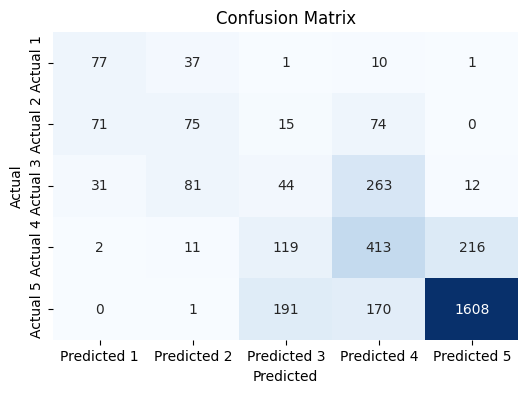

In [26]:
cm = confusion_matrix(y_test, y_pred_class)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=['Predicted 1', 'Predicted 2', 'Predicted 3', 'Predicted 4', 'Predicted 5'],
            yticklabels=['Actual 1', 'Actual 2', 'Actual 3', 'Actual 4', 'Actual 5'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()